# HW03: Practice with algorithm selection, grid search, cross validation, multiclass classification, and one-class classification.

[Name: Zeyang Yu /NetID: zyu355]

## Hello Students:
 Start by downloading HW03.ipynb from this folder. Then develop it into your solution.
- Write code where you see "... your code here ..." below.
  (You are welcome to use more than one cell.)
- If you have questions, please ask them in class, office hours, or piazza. Our TA
  and I are very happy to help with the programming (provided you start early
  enough, and provided we are not helping so much that we undermine your learning).
- When you are done, run these Notebook commands:
  - Shift-L (once, so that line numbers are visible)
  - Kernel > Restart and Run All (run all cells from scratch)
  - Esc S (save)
  - File > Download as > HTML
- Turn in:
  - HW03.ipynb to Canvas's HW03.ipynb assignment
  - HW03.html to Canvas's HW03.html assignment
  - As a check, download your files from Canvas to a new 'junk' folder. Try 'Kernel > Restart
  and Run All' on the '.ipynb' file to make sure it works. Glance through the '.html' file.
- Turn in partial solutions to Canvas before the deadline. e.g. Turn in part 1,
  then parts 1 and 2, then your whole solution. That way we can award partial credit
  even if you miss the deadline. We will grade your last submission before the deadline.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn import mixture

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, linear_model, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

## 1. Algorithm selection for multiclass classification by optical recognition of handwritten digits

- The [digits](https://scikit-learn.org/stable/datasets/toy_dataset.html#digits-dataset) dataset
  has 1797 labeled images of hand-written digits.
  - $X$ = `digits.data` has shape (1797, 64).
    - Each image $\mathbf{x}_i$ is represented as the $i$th row of 64 pixel values in the 2D
      `digits.data` array that corresponds to an 8x8 photo of a handwritten digit.
  - $y$ = `digits.target` has shape (1797,). Each $y_i$ is a number from 0 to 9 indicating
    the handwritten digit that was photographed and stored in $\mathbf{x}_i$.

### 1(a) Explore the digits dataset:
- Display the shapes of $X=$ `digits.data` and $y=$ `digits.target`.
- Display a copy of $\mathbf{x}_0$, the first row of `digits.data` reshaped to 8x8.
- Display $y_0$, the first target digit.

In [2]:
digits = datasets.load_digits()

In [4]:
X = digits.data
y = digits.target
print(f'The shape of X is {np.array(X).shape}.')
print(f'The shape of y is {np.array(y).shape}.')
x0 = np.reshape(digits.data[0,:],(8,8))
print(x0)
y0 = digits.target[0]
print(y0)

The shape of X is (1797, 64).
The shape of y is (1797,).
[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]
0


### 1(b) Run and read the next few cells to explore digits a little further.
Here is my code (which takes a few seconds) to plot the first 40 images:

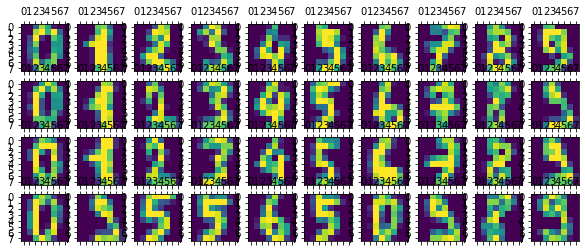

In [5]:
fig = plt.figure(figsize=(10, 4)) # new blank figure
gs = fig.add_gridspec(nrows=4, ncols=10) # grid of plot axes
for i in np.arange(40): # i goes from 0 to 39; or if we consider it as a 2-digit number, from 00 to 39
    ax = fig.add_subplot(gs[i // 10, i % 10]) # row = i's first digit, column = i's second digit
    ax.matshow(digits.images[i])

We can see from digits.target that the first three rows are repeats of 0 through 9,
but the fourth row seems to be random digits:

In [6]:
first_40_y_values = digits.target[0:40].copy()
first_40_y_values.reshape(4, 10)

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 9, 5, 5, 6, 5, 0, 9, 8, 9]])

Here I have split the digits data into training, validation, and test sets:

In [7]:
X = digits.data
y = digits.target
# split 80% training data, 20% "_tmp" for validation & test
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2,
                                                  random_state=0, stratify=y)
# of remaining 20%, split in half to get 10% validation, 10% test
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,
  random_state=0, stratify=y_tmp)

In [8]:
# (I added this cell on Mo 4/11/22 after originally posting HW03 on Fr 4/8/22.
#  It saves indices into the original data set of the train/validation/test data sets
#  to make it easier to plot the images corresponding to wrong predictions in 1(d).
#  --John Gillett)
# Here is how I wish I had done train_test_split() in the first place:
n_rows = digits.data.shape[0]
indices_train, indices_tmp = train_test_split(np.arange(n_rows), test_size=.2,
                                              random_state=0, stratify=y)
indices_valid, indices_test = train_test_split(indices_tmp, test_size=.5,
                                               random_state=0, stratify=y[indices_tmp])

# Then I should have run these lines, which aren't necessary today in light of the
# original calls to train_test_split() in the cell above.
if False: # False because all these arrays are already set in the original cell above.
    X_train == X[indices_train]
    X_valid == X[indices_valid]
    X_test == X[indices_test]
    y_train == y[indices_train]
    y_valid == y[indices_valid]
    y_test == y[indices_test]

# These lines are an unnecssary check to ensure I didn't change anything from the
# originally posted HW03, other than now the indices_train, indices_valid, and
# indices_test arrays are available.
assert np.all(X_train == X[indices_train])
assert np.all(X_valid == X[indices_valid])
assert np.all(X_test == X[indices_test])
assert np.all(y_train == y[indices_train])
assert np.all(y_valid == y[indices_valid])
assert np.all(y_test == y[indices_test])

## 1(c) Use algorithm selection on training and validation data to choose a best classifier.
Loop through these four classifiers and corresponding parameters, doing a grid search
to find the best hyperparameter setting. Use only the training data for the grid search.
- SVM:
  - Try all values of `kernel` in 'linear', 'rbf'.
  - Try all values of `C` in 0.01, 1, 100.
- logistic regression:
  - Use `max_iter=5000` to avoid a nonconvergence warning.
  - Try all values of `C` in 0.01, 1, 100.
- ID3 decision tree:
  - Use `criterion='entropy` to get our ID3 tree.
  - Try all values of `max_depth` in 1, 3, 5, 7.
- kNN:
  - (Use the default Euclidean distance).
  - Try all values of `n_neighbors` in 1, 2, 3, 4.

Hint:
- Make a list of the four classifiers without setting any hyperparameters.
- Make a list of four corresponding parameter dictionaries.
- Loop through 0, 1, 2, 3:
  - Run grid search on the $i$th classifier with the $i$th parameter dictionary on the
    training data. (The grid search does its own cross-validation using the training data.)
  - Use the $i$th classifier with its best hyperparameter settings (just `clf` from
    `clf = GridSearchCV(...)`) to find the accuracy of the model on the validation data, i.e.
    find `clf.score(X_valid, y_valid)`.
- Keep track, as your loop progresses, of:
  - the index $i$ of the best classifier (initialize it to `-1` or some other value)
  - the best accuracy score on validation data (initialize it to `-np.Inf`)
  - the best classifier with its hyperparameter settings, that is the best `clf` from
    `clf = GridSearchCV(...)` (initialize it to `None` or some other value)

I needed about 30 lines of code to do this. It took a minute to run.

In [9]:
# Make a list of the four classifiers
classifiers = [svm.SVC(), 
               linear_model.LogisticRegression(), 
               DecisionTreeClassifier(), 
               KNeighborsClassifier()]

# Make a list of four corresponding parameter dictionaries 
parameter = [
    {'kernel':('linear', 'rbf'),'C':[0.01, 1, 100]},
    {'max_iter':[5000],'C':[0.01, 1, 100]},
    {'criterion':['entropy'], 'max_depth':[1, 3, 5, 7]},
    {'n_neighbors':[1, 2, 3, 4],'metric':['euclidean']}
]
index = -1
best_clf = None
best_acc = -np.Inf
for i in range(4):
    clf = GridSearchCV(classifiers[i], parameter[i])
    clf.fit(X_train, y_train)
    if clf.score(X_valid, y_valid) > best_acc:
        index = i
        best_acc = clf.score(X_valid, y_valid)
        best_clf = clf.best_params_
    print(f'{clf.score(X_valid, y_valid):.3}')
    print(clf.best_params_)
print(f'The best accuracy score on validation data is {best_acc:.3}.')
print(f'The best classifier with its hyperparameter settings are {best_clf}.')

0.989
{'C': 1, 'kernel': 'rbf'}
0.972
{'C': 0.01, 'max_iter': 5000}
0.861
{'criterion': 'entropy', 'max_depth': 7}
0.989
{'metric': 'euclidean', 'n_neighbors': 3}
The best accuracy score on validation data is 0.989.
The best classifier with its hyperparameter settings are {'C': 1, 'kernel': 'rbf'}.


### 1(d) Evaluate on the test data the classifier and its hyperparameter settings from 1(c).
- Report `clf.score(X_test, y_test)`.
- Make a confusion matrix from the true `y_test` values and the corresponding $\hat{y}$ values
  predicted by `clf` on `X_test`.
- For each of the wrong predictions (where `y_test` and your $\hat{y}$ values disagree), show:
  - The index $i$ in `digits.data` (and `digits.target`) of that example $\mathbf{x}$
  - The correct label $y_i$
  - Your incorrect prediction $\hat{y}_i$
  - A plot of `digits.images[i]`

The score is 0.978.
{'C': 1, 'kernel': 'rbf'}
df:
    0   1   2   3   4   5   6   7   8   9
0  18   0   0   0   0   0   0   0   0   0
1   0  18   0   0   0   0   0   0   0   0
2   0   0  18   0   0   0   0   0   0   0
3   0   0   0  18   0   0   0   1   0   0
4   0   0   0   0  17   0   0   0   1   0
5   0   0   0   0   0  18   0   0   0   0
6   0   0   0   0   0   0  18   0   0   0
7   0   0   0   0   0   0   0  18   0   0
8   0   1   0   0   0   0   0   0  16   0
9   0   0   0   0   0   1   0   0   0  17
The index i in digits.data is [  37 1660  794 1118]
The correct label 𝑦i is [9 4 8 3]
The incorrect prediction 𝑦̂ 𝑖 is [5 8 1 7]


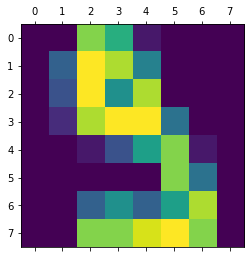

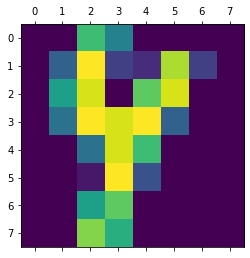

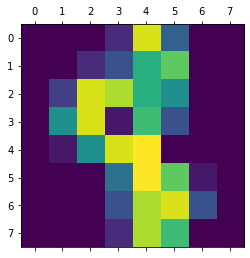

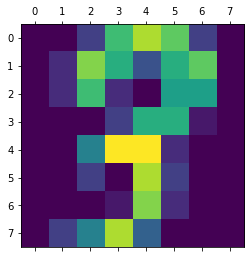

In [10]:
clf = GridSearchCV(classifiers[index], parameter[index])
clf.fit(X_train, y_train)
print(f'The score is {clf.score(X_test, y_test):.3}.')
print(clf.best_params_)
y_hat = clf.predict(X_test)
M = confusion_matrix(y_true=y_test, y_pred=y_hat)
df = pd.DataFrame(data=M) 
print(f'df:\n{df}')

m = np.where(y_test != y_hat)
i = indices_test[m]
print(f'The index i in digits.data is {i}')
print(f'The correct label 𝑦i is {y[i]}')
print(f'The incorrect prediction 𝑦̂ 𝑖 is {clf.predict(X[i])}')
for a in i:
    plt.matshow(digits.images[int(a)])
plt.show()

## 2. One-class classification (outlier detection)

### 2(a) There is an old gradebook of mine at [https://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt](https://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt).
Use `pd.read_table()` to read it into a DataFrame.

Hint: `pd.read_table()` has many parameters. Check its documentation to find three parameters to:
- Read from the given URL
- Use the separator '\s+', which means 'one or more whitespace characters'
- Skip the first 12 rows, as they are a note to students and nt part of the gradebook

In [11]:
df = pd.read_table(filepath_or_buffer='https://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt',
                   sep='\s+', skiprows=12)

### 2(b) Use `clf = mixture.GaussianMixture(n_components=1)` to make a one-class Gaussian model to decide which $\mathbf{x}=(\text{Exam1}, y=\text{Exam2})$ are outliers:

- Set a matrix X to the first two columns, Exam1 and Exam.
- These exams were worth 125 points each. Use the MinMaxScaler to transform scores to percentages in $[0, 100]$.
- Fit your classifier to X.
  
  Hint:
  - The reference page for `mixture.GaussianMixture` includes a `fit(X, y=None)` method
    with the comment that y is ignored (as this is an unsupervised learning algorithm--there
    is no $y$) but present for API consistency. So we can fit with just X.
  - I got a warning about "KMeans ... memory leak" I do not understand. You may ignore this
    warning if you see it. I still got satisfactory results.
- Print the center $\mathbf{\mu}$ and covariance matrix $\mathbf{\Sigma}$ from the two-variable
  $N_2(\mathbf{\mu}, \mathbf{\Sigma})$ distribution you estimated.

In [12]:
X = df[['Exam1', 'Exam2']].to_numpy()
scaler = MinMaxScaler(feature_range=(0,100))
X_scaled = scaler.fit_transform(X)
clf = mixture.GaussianMixture(n_components=1)
clf.fit(X_scaled, y=None)
print(f'The center 𝜇 is {clf.means_}')
print(f'The covariance matrix 𝚺 is {clf.covariances_}')

The center 𝜇 is [[82.81329923 72.75795564]]
The covariance matrix 𝚺 is [[[155.51123078  74.82542352]
  [ 74.82542352 189.87476472]]]


### 2(c) Here I have given you code to make a contour plot of the negative log likelihood $-\ln f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ for $\mathbf{X} \sim N_2(\mathbf{\mu}, \mathbf{\Sigma})$, provided you have set `clf`.

```
# make contour plot of log-likelihood of samples from clf.score_samples()
margin = 10
x = np.linspace(0 - margin, 100 + margin)
y = np.linspace(0 - margin, 100 + margin)
grid_x, grid_y = np.meshgrid(x, y)
two_column_grid_x_grid_y = np.array([grid_x.ravel(), grid_y.ravel()]).T
negative_log_pdf_values = -clf.score_samples(two_column_grid_x_grid_y)
grid_z = negative_log_pdf_values
grid_z = grid_z.reshape(grid_x.shape)
plt.contour(grid_x, grid_y, grid_z, levels=10) # X, Y, Z
plt.title('(Exam1, Exam2) pairs')
```

Paste my code into your code cell below and add more code:
- Add black $x$- and $y$- axes. Label them Exam1 and Exam2.
- Plot the data points in blue.
- Plot $\mathbf{\mu}=$ `clf.means_` as a big lime dot.
- Overplot (i.e. plot again) in red the 8 outliers determined by a threshold consisting
  of the 0.02 quantile of the pdf values $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$
  for each $\mathbf{x}$ in X.
  
  Hint: `clf.score_samples(X)` gives log likelihood, so `np.exp(clf.score_samples(X))`
  gives the required $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ values.

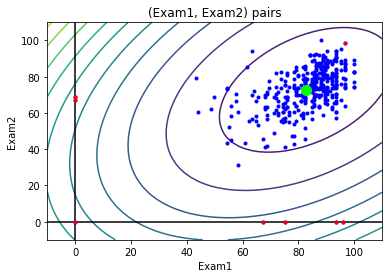

In [13]:
# make contour plot of log-likelihood of samples from clf.score_samples()
margin = 10
x = np.linspace(0 - margin, 100 + margin)
y = np.linspace(0 - margin, 100 + margin)
grid_x, grid_y = np.meshgrid(x, y)
two_column_grid_x_grid_y = np.array([grid_x.ravel(), grid_y.ravel()]).T
negative_log_pdf_values = -clf.score_samples(two_column_grid_x_grid_y)
grid_z = negative_log_pdf_values
grid_z = grid_z.reshape(grid_x.shape)
plt.contour(grid_x, grid_y, grid_z, levels=10) # X, Y, Z
plt.title('(Exam1, Exam2) pairs')

# Plot black 𝑥- and 𝑦-axes. Label them Exam1 and Exam2
plt.xlabel('Exam1')
plt.ylabel('Exam2')
plt.vlines(0,-10,110,colors='black')
plt.hlines(0,-10,110,colors='black')

# Plot the data points in blue
plt.plot(X_scaled[:,0], X_scaled[:,1], ".b")

# Plot  𝜇=  clf.means_ as a big lime dot.
plt.plot(clf.means_[0][0],clf.means_[0][1],marker='.',markersize = 20,color = 'lime')

# Overplot (i.e. plot again) in red the 8 outliers 
scores = np.exp(clf.score_samples(X))
outliers = X_scaled[scores<=np.quantile(scores,0.02)]

plt.plot(outliers[:,0],outliers[:,1],".r")

### What characterizes 7 of these 8 outliers? Write your answer in a markdown cell.

In [14]:
outliers

array([[96.8       , 98.36065574],
       [96.        ,  0.        ],
       [93.6       ,  0.        ],
       [75.2       ,  0.        ],
       [ 0.        , 68.85245902],
       [ 0.        , 67.21311475],
       [67.2       ,  0.        ],
       [ 0.        ,  0.        ]])

We can also see there are 7 outliers which have 0 point in exam1 or exam2 from the graph, which means there are 7 students missed the exam1 or exam2.  

### 2(d) Write a little code to report whether, by the 0.02 quantile criterion, $\mathbf{x}=$ (Exam1=50, Exam2=100) is an outlier.

Hint: Compare $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ to your threshold

In [15]:
X = [[50, 100]]
if np.exp(clf.score_samples(X)) <= np.quantile(scores, 0.02):
    print('x =(Exam1=50, Exam2=100) is outlier')
else:
    print('x =(Exam1=50, Exam2=100) is not outlier')

x =(Exam1=50, Exam2=100) is outlier
